In [1]:
import tensorflow as tf
import tensorflow_io as tfio
from efficientnet.tfkeras import EfficientNetB3

from math import log10, sqrt
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
import pandas as pd

In [2]:
images = glob.glob('data/images/Train/*.jpg')
model = tf.keras.models.load_model('model/effnet_colorizer.h5', compile=False)
effnet_model = EfficientNetB3(weights='imagenet', include_top=True)

In [3]:
train_images, validation_images = train_test_split(images, test_size=0.4, random_state=2021)
validation_images, test_images = train_test_split(validation_images, test_size=0.5, random_state=2021)

# Helper functions

In [4]:
def read_image(image_path):
    return tf.io.decode_jpeg(tf.io.read_file(image_path))

def prepare_data(img):
    img_norm = tf.cast(img, tf.float32)
    img_norm = img_norm / 255.
    lab_img = tfio.experimental.color.rgb_to_lab(img_norm)
    l_img = tf.expand_dims(lab_img[:, :, 0], axis=0)
    
    img_resized = tf.image.resize(img, (300, 300))
    img_resized = img_resized / 255.
    img_resized = tf.expand_dims(img_resized, axis=0)
    embeddings = effnet_model.predict(img_resized)
    return l_img, embeddings

def fill_lab_img(l_img, ab_img):
    img = np.zeros((256, 256, 3))
    img[:,:, 0] = l_img
    img[:, :, 1:] = ab_img
    
    return img

In [5]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [31]:
evaluation = {'SSIM': [], 'PSNR': []}
for image in test_images:
    img = read_image(image)
    
    l_img, embeddings = prepare_data(img)
    pred_ab = model.predict([l_img, embeddings])
    pred_ab = np.squeeze(pred_ab, axis=0) * 128
    lab_img = fill_lab_img(l_img, pred_ab)
    rgb_img = tf.cast(tfio.experimental.color.lab_to_rgb(lab_img) * 255, tf.uint8)
    
    psnr = PSNR(img.numpy(), rgb_img.numpy())
    ssim = tf.image.ssim(img, rgb_img, max_val=255)
    
    evaluation['SSIM'].append(ssim.numpy())
    evaluation['PSNR'].append(psnr)

In [32]:
df = pd.DataFrame(evaluation)

In [48]:
df

,SSIM,PSNR
0,0.961389,30.670614
1,0.875216,28.953440
2,0.937644,31.260372
3,0.992352,35.253560
4,0.863486,30.606408
...,...,...
1675,0.957924,31.969399
1676,0.914496,29.284625
1677,0.872885,30.440243
1678,0.953973,29.928585


In [45]:
print('Max PSNR: {} at position {}'.format(round(df['PSNR'].max(), 2), df['PSNR'].idxmax()))
print('Max SSIM: {} at position {}'.format(round(df['SSIM'].max(), 2), df['SSIM'].idxmax()))

Max PSNR: 44.08 at position 1240
Max SSIM: 1.0 at position 1096


In [46]:
# Lets visually inspect
img = read_image(test_images[1240])
l_img, embeddings = prepare_data(img)
pred_ab = model.predict([l_img, embeddings])
pred_ab = np.squeeze(pred_ab, axis=0) * 128
lab_img = fill_lab_img(l_img, pred_ab)
rgb_img = tf.cast(tfio.experimental.color.lab_to_rgb(lab_img) * 255, tf.uint8)

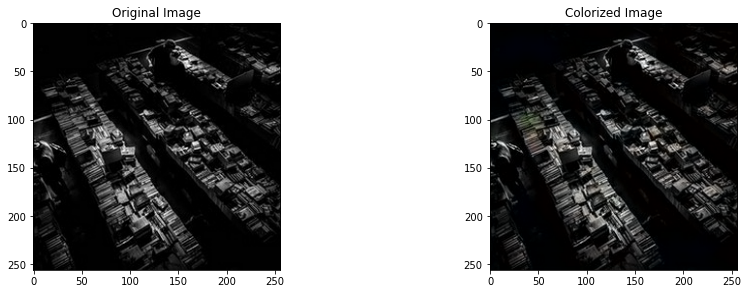

In [47]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(222)
plt.title('Colorized Image')
plt.imshow(rgb_img)